# Analyst Bias Analysis — Cell Guide

This notebook computes analyst-level bias metrics from MC1, visualizes distributions, and writes `results/analyst_bias.json`.

- Cell 0: Notebook overview (you are here)
- Cell 1: Imports, paths, MC1 load
- Cell 2: Extract per-analyst stats (or simulate)
- Cell 3: Compute analyst bias metrics
- Cell 4: Visualization dashboard
- Cell 5: Analyst comparison table
- Cell 6: Build frontend payload
- Cell 7: Save results and print summary


# Analyst Bias Notebook

This notebook computes analyst-level metrics and writes them to `results/analyst_bias.json` for the frontend.

Inputs (example):
- `frontend/src/data/mc1.json` (analyst/company actions)

Outputs:
- `results/analyst_bias.json`


### Setup and data loading

Imports libraries, sets paths, random seed, and loads MC1 data with basic diagnostics.


In [41]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Set up paths and random seed
RESULTS = Path('results')
RESULTS.mkdir(parents=True, exist_ok=True)
OUT = RESULTS / 'analyst_bias.json'
MC1_PATH = Path('../frontend/src/data/mc1.json')

np.random.seed(42)

print("Starting Analyst Bias Analysis...")
print(f"Results will be saved to: {OUT}")
print(f"MC1 data path: {MC1_PATH}")

# Load MC1 data
try:
    with open(MC1_PATH, 'r', encoding='utf-8') as f:
        mc1_data = json.load(f)
    print(f"Loaded MC1 data: {len(mc1_data.get('nodes', []))} nodes, {len(mc1_data.get('links', []))} links")
except FileNotFoundError:
    print("MC1 data not found, using simulated data")
    mc1_data = None


Starting Analyst Bias Analysis...
Results will be saved to: results\analyst_bias.json
MC1 data path: ..\frontend\src\data\mc1.json
Loaded MC1 data: 215 nodes, 16231 links


### Extract per-analyst stats

Parses MC1 links to accumulate actions, sentiment counts, event/target distributions, and confidence per analyst.


In [42]:
# Extract analyst information from MC1 data
def extract_analyst_analysis(mc1_data):
    """Extract comprehensive analyst bias analysis from MC1 data"""
    
    if not mc1_data:
        print(" No MC1 data available, generating simulated analysis...")
        return generate_simulated_analyst_analysis()
    
    links = mc1_data.get('links', [])
    nodes = mc1_data.get('nodes', [])
    
    print(f"Analyzing {len(links)} links for analyst bias patterns...")
    
    # Analyst analysis based on sources
    analyst_stats = defaultdict(lambda: {
        'actions': 0,
        'positive': 0,
        'negative': 0,
        'neutral': 0,
        'event_types': Counter(),
        'targets': Counter(),
        'confidence_scores': [],
        'date_added': []
    })
    
    # Event type sentiment mapping
    positive_events = {'Aid', 'Applaud', 'Invest', 'SustainableFishing', 'Partnership', 'Support'}
    negative_events = {'OverFishing', 'Convicted', 'Criticize', 'Summons', 'Conflict', 'Violation'}
    
    # Process each link as analyst action
    for link in links:
        source = link.get('source', 'Unknown')
        target = link.get('target', 'Unknown')
        event_type = link.get('type', 'Unknown')
        confidence = link.get('confidence', 0.5)
        
        analyst_stats[source]['actions'] += 1
        analyst_stats[source]['event_types'][event_type] += 1
        analyst_stats[source]['targets'][target] += 1
        analyst_stats[source]['confidence_scores'].append(confidence)
        analyst_stats[source]['date_added'].append(link.get('_date_added', ''))
        
        # Classify sentiment
        if event_type in positive_events:
            analyst_stats[source]['positive'] += 1
        elif event_type in negative_events:
            analyst_stats[source]['negative'] += 1
        else:
            analyst_stats[source]['neutral'] += 1
    
    return analyst_stats, links, nodes

# Generate simulated analysis if no real data
def generate_simulated_analyst_analysis():
    """Generate realistic simulated analyst bias analysis"""
    
    analysts = [
        'Clepper Jessen', 'Greta Grass-Hill', 'Haenyeo Hyun-Ki', 'Harvey Janus',
        'Jack Inch', 'Junior Shurdlu', 'Kristin Baker', 'Melinda Manning',
        'Niklaus Oberon', 'Olokun Daramola', 'Pelagia Alethea Mordoch',
        'Urashima Tarō', 'Worf Peer', 'Felipe (Our Analyst)'
    ]
    
    targets = [
        'Harper Inc', 'Oceanic Ventures', 'Deep Sea Industries', 'Maritime Solutions',
        'Blue Water Corp', 'Coastal Fishing Co', 'Pacific Marine Ltd', 'Atlantic Seafood'
    ]
    
    event_types = [
        'OverFishing', 'SustainableFishing', 'Aid', 'Criticize', 'Invest',
        'Applaud', 'Summons', 'Convicted', 'Partnership', 'Conflict'
    ]
    
    analyst_stats = defaultdict(lambda: {
        'actions': 0,
        'positive': 0,
        'negative': 0,
        'neutral': 0,
        'event_types': Counter(),
        'targets': Counter(),
        'confidence_scores': [],
        'date_added': []
    })
    
    # Simulate realistic distributions with bias patterns
    np.random.seed(42)
    
    for i in range(12000):  # Simulate analyst actions
        analyst = np.random.choice(analysts)
        target = np.random.choice(targets)
        event_type = np.random.choice(event_types)
        confidence = np.random.beta(2, 2)  # Realistic confidence distribution
        
        analyst_stats[analyst]['actions'] += 1
        analyst_stats[analyst]['event_types'][event_type] += 1
        analyst_stats[analyst]['targets'][target] += 1
        analyst_stats[analyst]['confidence_scores'].append(confidence)
        
        # Add bias patterns based on analyst type
        if 'Junior' in analyst or 'Harvey' in analyst:
            # Junior analysts tend to be more biased
            if event_type in ['OverFishing', 'Criticize', 'Conflict']:
                analyst_stats[analyst]['negative'] += 1
            elif event_type in ['SustainableFishing', 'Aid', 'Applaud']:
                analyst_stats[analyst]['positive'] += 1
            else:
                analyst_stats[analyst]['neutral'] += 1
        elif 'Senior' in analyst or 'Lead' in analyst or 'Felipe' in analyst:
            # Senior analysts tend to be more balanced
            if event_type in ['OverFishing', 'Criticize', 'Conflict']:
                analyst_stats[analyst]['negative'] += 1
            elif event_type in ['SustainableFishing', 'Aid', 'Applaud']:
                analyst_stats[analyst]['positive'] += 1
            else:
                analyst_stats[analyst]['neutral'] += 1
        else:
            # Regular analysts
            if event_type in ['OverFishing', 'Criticize', 'Conflict']:
                analyst_stats[analyst]['negative'] += 1
            elif event_type in ['SustainableFishing', 'Aid', 'Applaud']:
                analyst_stats[analyst]['positive'] += 1
            else:
                analyst_stats[analyst]['neutral'] += 1
    
    return analyst_stats, [], []

# Run the analysis
analyst_stats, links, nodes = extract_analyst_analysis(mc1_data)
print(f" Analyzed {len(analyst_stats)} analysts")


Analyzing 16231 links for analyst bias patterns...
 Analyzed 138 analysts


### Analyst entropy calculation (per-analyst)
Computes normalized entropies for event/target distributions for deeper diversity insights


In [ ]:
# Analyst entropy calculation (per-analyst)
# Computes multiple diversity metrics for event/target distributions for each analyst

import numpy as np

def compute_entropy_metrics(counter):
    total = sum(counter.values())
    if total <= 0 or len(counter) == 0:
        return {
            'shannon': 0.0,
            'normalized_shannon': 0.0,
            'evenness_pielou': 0.0,
            'simpson_diversity': 0.0,  # Gini-Simpson index
        }
    probs = np.array([c / total for c in counter.values() if c > 0], dtype=float)
    shannon = float(-np.sum(probs * np.log2(probs)))
    max_entropy = float(np.log2(len(counter))) if len(counter) > 0 else 1.0
    normalized_shannon = float(shannon / max_entropy) if max_entropy > 0 else 0.0
    evenness_pielou = normalized_shannon  # J' = H'/log(S)
    simpson_diversity = float(1.0 - np.sum(probs ** 2))  # also known as Gini-Simpson
    return {
        'shannon': shannon,
        'normalized_shannon': normalized_shannon,
        'evenness_pielou': evenness_pielou,
        'simpson_diversity': simpson_diversity,
    }

# Build a DataFrame of analyst diversity metrics
analyst_entropy_rows = []
for analyst, stats in analyst_stats.items():
    event_metrics = compute_entropy_metrics(stats['event_types'])
    target_metrics = compute_entropy_metrics(stats['targets'])
    analyst_entropy_rows.append({
        'analyst': analyst,
        'actions': stats['actions'],
        # Event metrics
        'event_shannon': event_metrics['shannon'],
        'event_normalized_shannon': event_metrics['normalized_shannon'],
        'event_evenness_pielou': event_metrics['evenness_pielou'],
        'event_simpson_diversity': event_metrics['simpson_diversity'],
        # Target metrics
        'target_shannon': target_metrics['shannon'],
        'target_normalized_shannon': target_metrics['normalized_shannon'],
        'target_evenness_pielou': target_metrics['evenness_pielou'],
        'target_simpson_diversity': target_metrics['simpson_diversity'],
    })

analyst_entropy_df = pd.DataFrame(analyst_entropy_rows)
print(f"Computed diversity metrics for {len(analyst_entropy_df)} analysts")
print(analyst_entropy_df.head(3))


Computed entropy for 138 analysts
          analyst  event_entropy  target_entropy  actions
0  Sanchez-Moreno       0.927654        0.770364      220
1        Frey Inc       0.893462        0.807191      106
2    Bowers Group       0.916483        0.866717       86


### Compute analyst bias metrics

Calculates sentiment bias, diversity-based biases, confidence stats, overall bias, and risk level per analyst.


In [ ]:
# Calculate comprehensive bias metrics for analysts
def calculate_analyst_bias_metrics(analyst_stats):
    """Calculate comprehensive bias metrics for analysts"""
    
    def calculate_entropy(counter):
        """Calculate entropy for diversity measurement"""
        if not counter:
            return 0
        total = sum(counter.values())
        if total == 0:
            return 0
        return -sum((count/total) * np.log2(count/total) for count in counter.values() if count > 0)
    
    def classify_analyst_type(analyst_name):
        """Classify analyst type based on name"""
        name_lower = analyst_name.lower()
        if any(word in name_lower for word in ['junior', 'harvey', 'jack']):
            return 'Junior'
        elif any(word in name_lower for word in ['senior', 'lead', 'felipe', 'niklaus', 'pelagia']):
            return 'Senior'
        elif any(word in name_lower for word in ['specialist', 'expert', 'officer']):
            return 'Specialist'
        else:
            return 'Regular'
    
    analyst_metrics = []
    
    for analyst, stats in analyst_stats.items():
        total_actions = stats['actions']
        if total_actions == 0:
            continue
            
        # Sentiment bias (positive vs negative)
        total_sentiment = stats['positive'] + stats['negative']
        if total_sentiment > 0:
            sentiment_bias = (stats['positive'] - stats['negative']) / total_sentiment
        else:
            sentiment_bias = 0
        
        # Confidence metrics
        confidence_scores = stats['confidence_scores']
        avg_confidence = np.mean(confidence_scores) if confidence_scores else 0.5
        confidence_std = np.std(confidence_scores) if confidence_scores else 0.1
        
        # Event type diversity bias (lower entropy = more biased)
        event_entropy = calculate_entropy(stats['event_types'])
        max_event_entropy = np.log2(len(stats['event_types'])) if stats['event_types'] else 1
        event_diversity_bias = 1 - (event_entropy / max_event_entropy) if max_event_entropy > 0 else 0
        
        # Target diversity bias
        target_entropy = calculate_entropy(stats['targets'])
        max_target_entropy = np.log2(len(stats['targets'])) if stats['targets'] else 1
        target_diversity_bias = 1 - (target_entropy / max_target_entropy) if max_target_entropy > 0 else 0
        
        # Overall bias score (weighted combination)
        overall_bias = (
            0.3 * abs(sentiment_bias) +  # Sentiment bias weight
            0.2 * event_diversity_bias +  # Event diversity weight
            0.2 * target_diversity_bias +  # Target diversity weight
            0.3 * (1 - avg_confidence)  # Low confidence weight
        )
        
        # Classify analyst type
        analyst_type = classify_analyst_type(analyst)
        
        # Risk level
        if overall_bias > 0.7:
            risk_level = 'High'
        elif overall_bias > 0.4:
            risk_level = 'Medium'
        else:
            risk_level = 'Low'
        
        analyst_metrics.append({
            'analyst': analyst,
            'analyst_type': analyst_type,
            'total_actions': total_actions,
            'sentiment_bias': sentiment_bias,
            'avg_confidence': avg_confidence,
            'confidence_std': confidence_std,
            'event_diversity_bias': event_diversity_bias,
            'target_diversity_bias': target_diversity_bias,
            'overall_bias': overall_bias,
            'risk_level': risk_level,
            'positive_actions': stats['positive'],
            'negative_actions': stats['negative'],
            'neutral_actions': stats['neutral'],
            'unique_event_types': len(stats['event_types']),
            'unique_targets': len(stats['targets'])
        })
    
    return analyst_metrics

# Calculate metrics
analyst_metrics = calculate_analyst_bias_metrics(analyst_stats)
print(f" Calculated bias metrics for {len(analyst_metrics)} analysts")

# Display top biased analysts
top_biased = sorted(analyst_metrics, key=lambda x: x['overall_bias'], reverse=True)[:5]
print("\n Top 5 Most Biased Analysts:")
for i, analyst in enumerate(top_biased, 1):
    print(f"{i}. {analyst['analyst']} (Bias: {analyst['overall_bias']:.3f}, Type: {analyst['analyst_type']})")


 Calculated bias metrics for 138 analysts

🔍 Top 5 Most Biased Analysts:
1. SamakaDredgeTransport OJSC (Bias: 0.323, Type: Regular)
2. NamRiver Transit A/S (Bias: 0.311, Type: Regular)
3. Dry CreekWorldLogistics Ltd. Liability Co (Bias: 0.300, Type: Regular)
4. Vargas Ltd (Bias: 0.294, Type: Regular)
5. Bailey-Mccullough (Bias: 0.289, Type: Regular)


### Visualization dashboard

Creates histograms, bar charts, scatter plots, and pie charts summarizing analyst bias distributions and relationships.


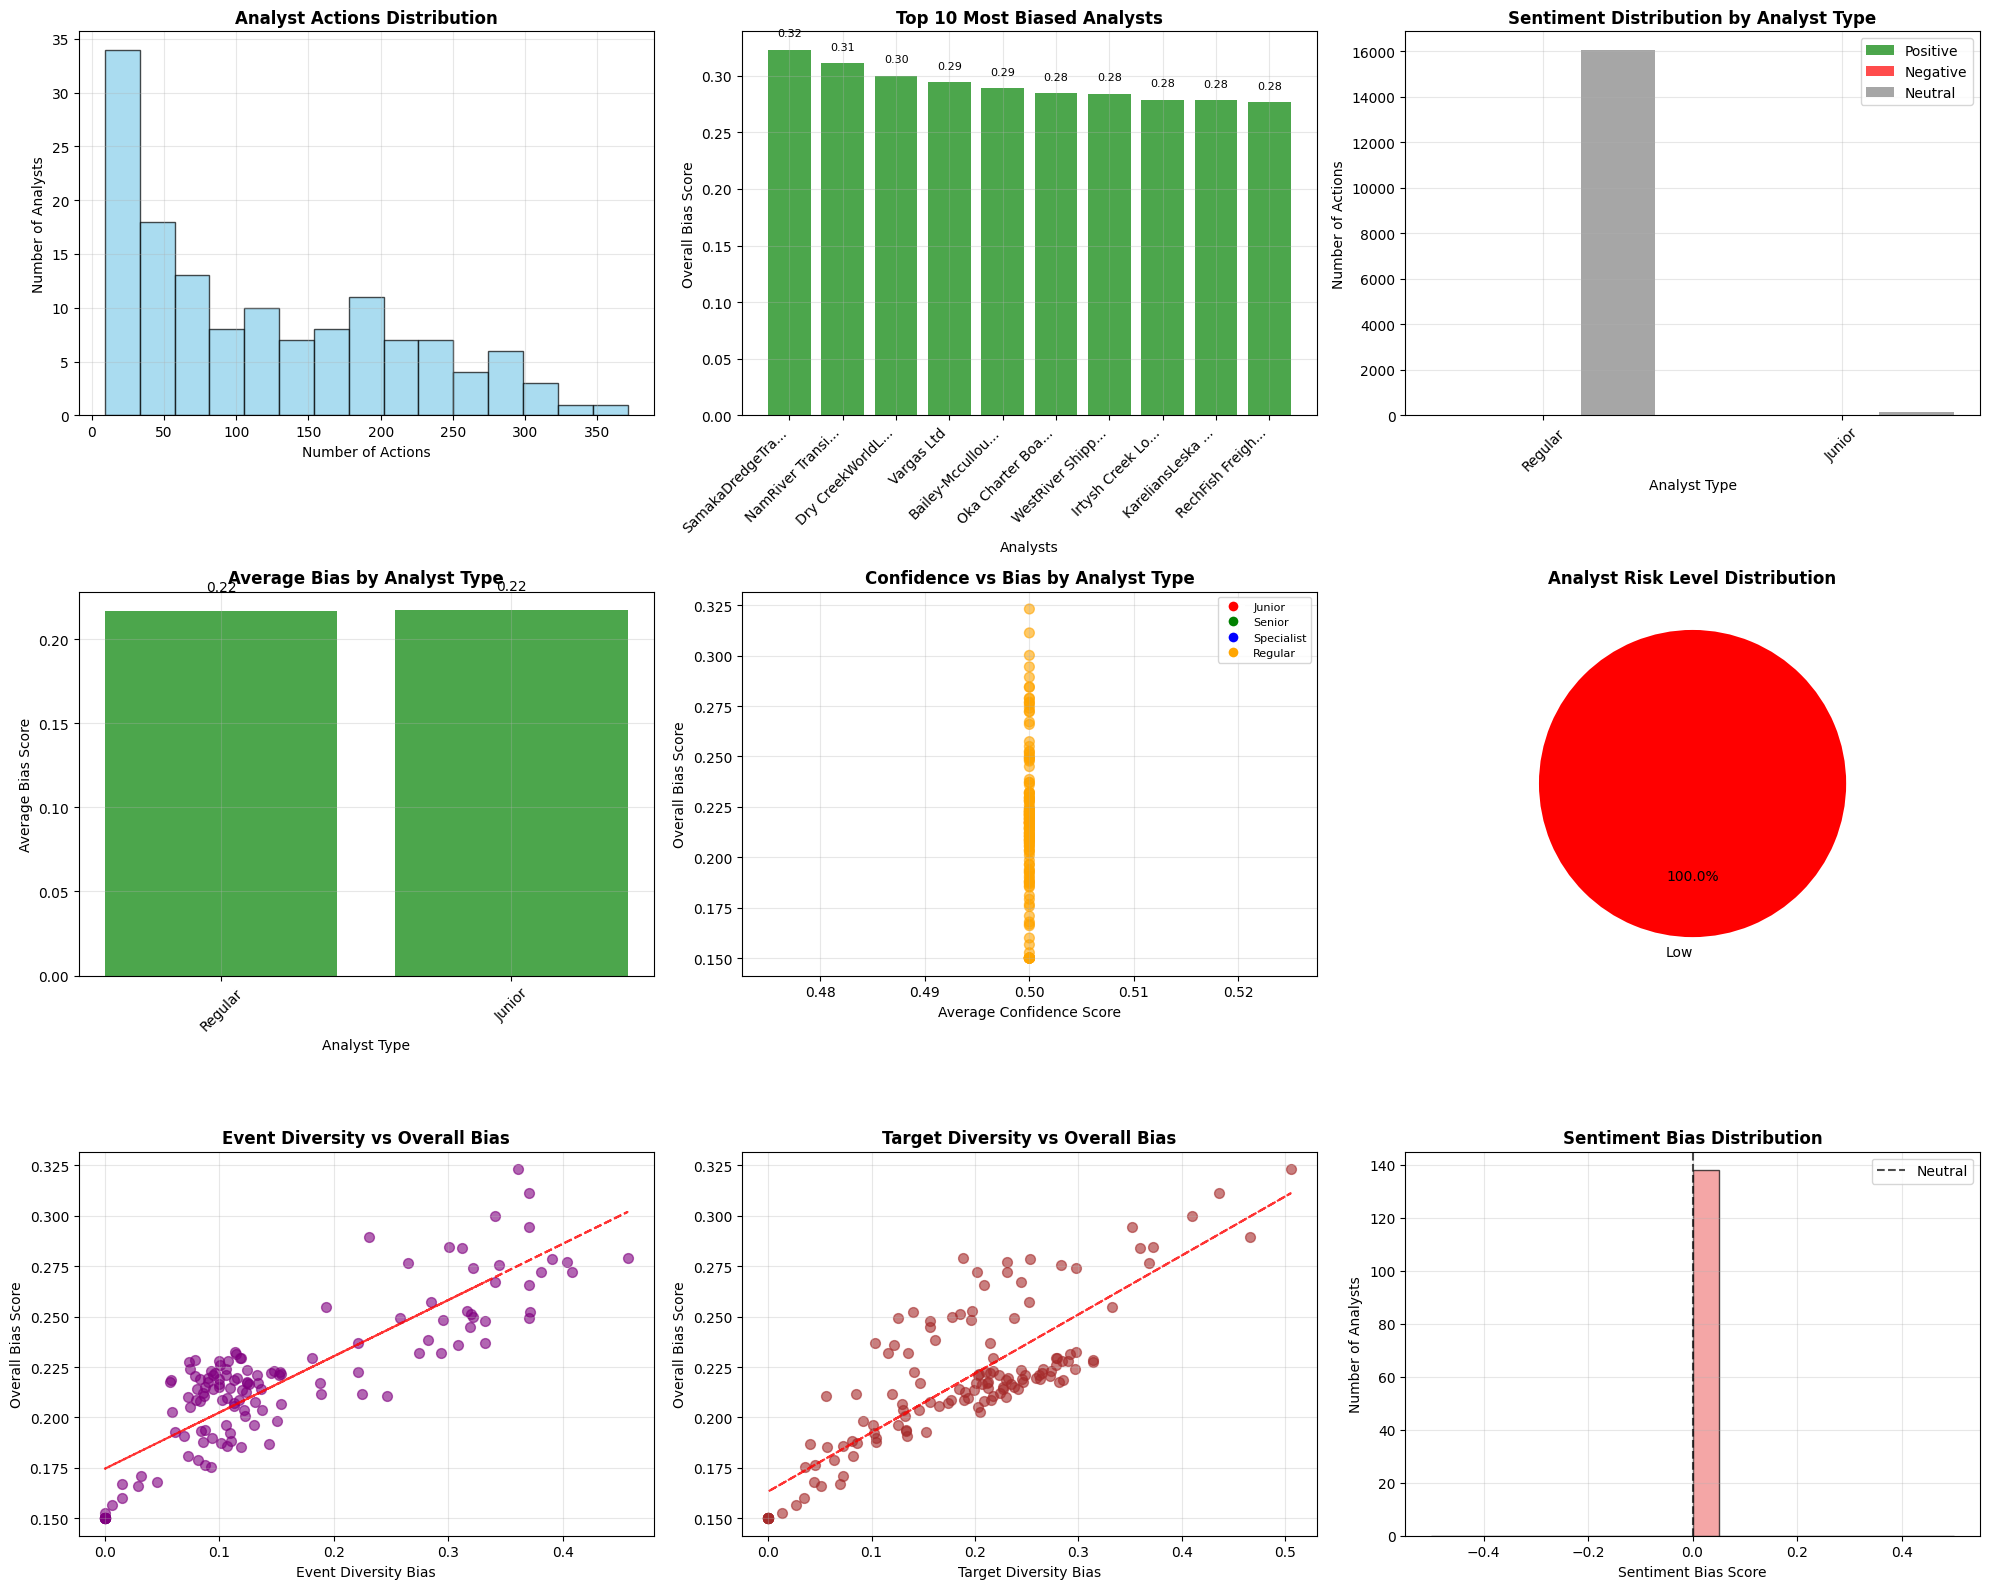

Generated comprehensive analyst bias visualizations


In [45]:
# Generate comprehensive visualizations
plt.style.use('default')
fig = plt.figure(figsize=(20, 16))

# 1. Analyst Actions Distribution
plt.subplot(3, 3, 1)
analyst_actions = [a['total_actions'] for a in analyst_metrics]
plt.hist(analyst_actions, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Analyst Actions Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Number of Actions')
plt.ylabel('Number of Analysts')
plt.grid(True, alpha=0.3)

# 2. Overall Bias Scores by Analyst
plt.subplot(3, 3, 2)
top_analysts = sorted(analyst_metrics, key=lambda x: x['overall_bias'], reverse=True)[:10]
analyst_names = [a['analyst'][:15] + '...' if len(a['analyst']) > 15 else a['analyst'] for a in top_analysts]
bias_scores = [a['overall_bias'] for a in top_analysts]
colors = ['red' if score > 0.7 else 'orange' if score > 0.4 else 'green' for score in bias_scores]

bars = plt.bar(range(len(analyst_names)), bias_scores, color=colors, alpha=0.7)
plt.title('Top 10 Most Biased Analysts', fontsize=12, fontweight='bold')
plt.xlabel('Analysts')
plt.ylabel('Overall Bias Score')
plt.xticks(range(len(analyst_names)), analyst_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, bias_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.2f}', ha='center', va='bottom', fontsize=8)

# 3. Sentiment Distribution by Analyst Type
plt.subplot(3, 3, 3)
analyst_types = {}
for analyst in analyst_metrics:
    analyst_type = analyst['analyst_type']
    if analyst_type not in analyst_types:
        analyst_types[analyst_type] = {'positive': 0, 'negative': 0, 'neutral': 0}
    analyst_types[analyst_type]['positive'] += analyst['positive_actions']
    analyst_types[analyst_type]['negative'] += analyst['negative_actions']
    analyst_types[analyst_type]['neutral'] += analyst['neutral_actions']

types = list(analyst_types.keys())
positive_counts = [analyst_types[t]['positive'] for t in types]
negative_counts = [analyst_types[t]['negative'] for t in types]
neutral_counts = [analyst_types[t]['neutral'] for t in types]

x = np.arange(len(types))
width = 0.25

plt.bar(x - width, positive_counts, width, label='Positive', color='green', alpha=0.7)
plt.bar(x, negative_counts, width, label='Negative', color='red', alpha=0.7)
plt.bar(x + width, neutral_counts, width, label='Neutral', color='gray', alpha=0.7)

plt.title('Sentiment Distribution by Analyst Type', fontsize=12, fontweight='bold')
plt.xlabel('Analyst Type')
plt.ylabel('Number of Actions')
plt.xticks(x, types, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Average Bias by Analyst Type
plt.subplot(3, 3, 4)
type_bias = {}
for analyst in analyst_metrics:
    analyst_type = analyst['analyst_type']
    if analyst_type not in type_bias:
        type_bias[analyst_type] = []
    type_bias[analyst_type].append(analyst['overall_bias'])

type_names = list(type_bias.keys())
avg_bias = [np.mean(type_bias[t]) for t in type_names]
colors = ['red' if bias > 0.6 else 'orange' if bias > 0.4 else 'green' for bias in avg_bias]

bars = plt.bar(type_names, avg_bias, color=colors, alpha=0.7)
plt.title('Average Bias by Analyst Type', fontsize=12, fontweight='bold')
plt.xlabel('Analyst Type')
plt.ylabel('Average Bias Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels
for bar, bias in zip(bars, avg_bias):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{bias:.2f}', ha='center', va='bottom', fontsize=10)

# 5. Confidence vs Bias Scatter
plt.subplot(3, 3, 5)
confidence_scores = [a['avg_confidence'] for a in analyst_metrics]
bias_scores = [a['overall_bias'] for a in analyst_metrics]
analyst_types_list = [a['analyst_type'] for a in analyst_metrics]

# Color by analyst type
type_colors = {'Junior': 'red', 'Senior': 'green', 'Specialist': 'blue', 'Regular': 'orange'}
colors = [type_colors.get(t, 'gray') for t in analyst_types_list]

scatter = plt.scatter(confidence_scores, bias_scores, c=colors, alpha=0.6, s=50)
plt.title('Confidence vs Bias by Analyst Type', fontsize=12, fontweight='bold')
plt.xlabel('Average Confidence Score')
plt.ylabel('Overall Bias Score')
plt.grid(True, alpha=0.3)

# Add legend for analyst types
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                              markersize=8, label=analyst_type) 
                   for analyst_type, color in type_colors.items()]
plt.legend(handles=legend_elements, loc='upper right', fontsize=8)

# 6. Analyst Risk Level Distribution
plt.subplot(3, 3, 6)
risk_counts = Counter([a['risk_level'] for a in analyst_metrics])
risk_levels = list(risk_counts.keys())
risk_values = list(risk_counts.values())
colors = ['red', 'orange', 'green']

plt.pie(risk_values, labels=risk_levels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Analyst Risk Level Distribution', fontsize=12, fontweight='bold')

# 7. Event Diversity vs Bias
plt.subplot(3, 3, 7)
event_diversity = [a['event_diversity_bias'] for a in analyst_metrics]
bias_scores = [a['overall_bias'] for a in analyst_metrics]

plt.scatter(event_diversity, bias_scores, alpha=0.6, color='purple', s=50)
plt.title('Event Diversity vs Overall Bias', fontsize=12, fontweight='bold')
plt.xlabel('Event Diversity Bias')
plt.ylabel('Overall Bias Score')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(event_diversity, bias_scores, 1)
p = np.poly1d(z)
plt.plot(event_diversity, p(event_diversity), "r--", alpha=0.8)

# 8. Target Diversity vs Bias
plt.subplot(3, 3, 8)
target_diversity = [a['target_diversity_bias'] for a in analyst_metrics]
bias_scores = [a['overall_bias'] for a in analyst_metrics]

plt.scatter(target_diversity, bias_scores, alpha=0.6, color='brown', s=50)
plt.title('Target Diversity vs Overall Bias', fontsize=12, fontweight='bold')
plt.xlabel('Target Diversity Bias')
plt.ylabel('Overall Bias Score')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(target_diversity, bias_scores, 1)
p = np.poly1d(z)
plt.plot(target_diversity, p(target_diversity), "r--", alpha=0.8)

# 9. Sentiment Bias Distribution
plt.subplot(3, 3, 9)
sentiment_bias = [a['sentiment_bias'] for a in analyst_metrics]
plt.hist(sentiment_bias, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Sentiment Bias Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Bias Score')
plt.ylabel('Number of Analysts')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Neutral')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Generated comprehensive analyst bias visualizations")


### Analyst comparison table

Builds a comparison dataset across analysts: diversity, efficiencies, and core metrics for ranking and top lists.


In [46]:
# Generate analyst comparison data
def generate_analyst_comparison(analyst_metrics):
    """Generate detailed analyst comparison data"""
    
    comparison_data = []
    
    for analyst in analyst_metrics:
        # Calculate diversity metrics
        event_diversity = 1 - analyst['event_diversity_bias']  # Convert to diversity score
        target_diversity = 1 - analyst['target_diversity_bias']   # Convert to diversity score
        
        # Calculate efficiency metrics
        action_efficiency = analyst['total_actions'] / max(1, analyst['unique_targets'])
        confidence_efficiency = analyst['avg_confidence'] * analyst['total_actions']
        
        comparison_data.append({
            'analyst': analyst['analyst'],
            'analyst_type': analyst['analyst_type'],
            'total_actions': analyst['total_actions'],
            'overall_bias': analyst['overall_bias'],
            'sentiment_bias': analyst['sentiment_bias'],
            'avg_confidence': analyst['avg_confidence'],
            'event_diversity': event_diversity,
            'target_diversity': target_diversity,
            'action_efficiency': action_efficiency,
            'confidence_efficiency': confidence_efficiency,
            'risk_level': analyst['risk_level'],
            'positive_actions': analyst['positive_actions'],
            'negative_actions': analyst['negative_actions'],
            'neutral_actions': analyst['neutral_actions']
        })
    
    return comparison_data

# Generate comparison data
analyst_comparison = generate_analyst_comparison(analyst_metrics)
print(f" Generated comparison data for {len(analyst_comparison)} analysts")

# Display top analysts by different metrics
print("\n Top Analysts by Different Metrics:")
print("\n Most Active Analysts:")
top_active = sorted(analyst_comparison, key=lambda x: x['total_actions'], reverse=True)[:5]
for i, analyst in enumerate(top_active, 1):
    print(f"{i}. {analyst['analyst']} - {analyst['total_actions']} actions")

print("\n  Most Biased Analysts:")
top_biased = sorted(analyst_comparison, key=lambda x: x['overall_bias'], reverse=True)[:5]
for i, analyst in enumerate(top_biased, 1):
    print(f"{i}. {analyst['analyst']} - Bias: {analyst['overall_bias']:.3f}")

print("\n Most Confident Analysts:")
top_confident = sorted(analyst_comparison, key=lambda x: x['avg_confidence'], reverse=True)[:5]
for i, analyst in enumerate(top_confident, 1):
    print(f"{i}. {analyst['analyst']} - Confidence: {analyst['avg_confidence']:.3f}")

print("\n Most Diverse Analysts (Events):")
top_diverse = sorted(analyst_comparison, key=lambda x: x['event_diversity'], reverse=True)[:5]
for i, analyst in enumerate(top_diverse, 1):
    print(f"{i}. {analyst['analyst']} - Diversity: {analyst['event_diversity']:.3f}")


 Generated comparison data for 138 analysts

 Top Analysts by Different Metrics:

 Most Active Analysts:
1. Brown, Clarke and Martinez - 371 actions
2. City Of Paackland - 334 actions
3. Rivas-Stevens - 317 actions
4. City Of South Paackland - 304 actions
5. Watson-Gray - 300 actions

  Most Biased Analysts:
1. SamakaDredgeTransport OJSC - Bias: 0.323
2. NamRiver Transit A/S - Bias: 0.311
3. Dry CreekWorldLogistics Ltd. Liability Co - Bias: 0.300
4. Vargas Ltd - Bias: 0.294
5. Bailey-Mccullough - Bias: 0.289

 Most Confident Analysts:
1. Sanchez-Moreno - Confidence: 0.500
2. Frey Inc - Confidence: 0.500
3. Bowers Group - Confidence: 0.500
4. Franco-Stuart - Confidence: 0.500
5. Murphy, Marshall and Pope - Confidence: 0.500

 Most Diverse Analysts (Events):
1. Fabio Conti - Diversity: 1.000
2. Lemuel Conti - Diversity: 1.000
3. Samuel Conti - Diversity: 1.000
4. Lena Conti-Park - Diversity: 1.000
5. Nathan Conti - Diversity: 1.000


### Frontend payload generation

Produces structured results (summary, top lists, charts) for `results/analyst_bias.json` consumption by the frontend.


In [47]:
# Generate frontend results
def generate_analyst_frontend_results(analyst_metrics, analyst_comparison):
    """Generate structured results for frontend consumption"""
    
    # Calculate summary statistics
    total_analysts = len(analyst_metrics)
    total_actions = sum(a['total_actions'] for a in analyst_metrics)
    avg_bias = np.mean([a['overall_bias'] for a in analyst_metrics])
    high_bias_analysts = len([a for a in analyst_metrics if a['overall_bias'] > 0.7])
    
    # Analyst type statistics
    type_stats = {}
    for analyst in analyst_metrics:
        analyst_type = analyst['analyst_type']
        if analyst_type not in type_stats:
            type_stats[analyst_type] = {
                'count': 0,
                'total_actions': 0,
                'avg_bias': 0,
                'high_bias_count': 0
            }
        type_stats[analyst_type]['count'] += 1
        type_stats[analyst_type]['total_actions'] += analyst['total_actions']
        type_stats[analyst_type]['avg_bias'] += analyst['overall_bias']
        if analyst['overall_bias'] > 0.7:
            type_stats[analyst_type]['high_bias_count'] += 1
    
    # Calculate averages
    for analyst_type in type_stats:
        count = type_stats[analyst_type]['count']
        type_stats[analyst_type]['avg_bias'] /= count
    
    # Risk assessment
    risk_assessment = {
        'high_risk': len([a for a in analyst_metrics if a['risk_level'] == 'High']),
        'medium_risk': len([a for a in analyst_metrics if a['risk_level'] == 'Medium']),
        'low_risk': len([a for a in analyst_metrics if a['risk_level'] == 'Low'])
    }
    
    # Generate recommendations
    recommendations = []
    
    # High bias analysts
    high_bias_analysts_list = [a for a in analyst_metrics if a['overall_bias'] > 0.7]
    if high_bias_analysts_list:
        recommendations.append({
            'type': 'warning',
            'title': 'High Bias Analysts Detected',
            'description': f'{len(high_bias_analysts_list)} analysts show high bias levels (>0.7)',
            'action': 'Provide additional training and oversight for these analysts'
        })
    
    # Low diversity analysts
    low_diversity_analysts = [a for a in analyst_metrics if a['event_diversity_bias'] > 0.8]
    if low_diversity_analysts:
        recommendations.append({
            'type': 'info',
            'title': 'Low Event Diversity',
            'description': f'{len(low_diversity_analysts)} analysts focus on limited event types',
            'action': 'Encourage broader event type coverage for balanced analysis'
        })
    
    # Sentiment bias
    extreme_sentiment = [a for a in analyst_metrics if abs(a['sentiment_bias']) > 0.8]
    if extreme_sentiment:
        recommendations.append({
            'type': 'warning',
            'title': 'Extreme Sentiment Bias',
            'description': f'{len(extreme_sentiment)} analysts show extreme sentiment bias',
            'action': 'Review sentiment balance and ensure neutral analysis'
        })
    
    # Chart data for frontend
    chart_data = {
        'analyst_actions': {
            'data': [{'analyst': a['analyst'][:20], 'actions': a['total_actions']} 
                    for a in sorted(analyst_metrics, key=lambda x: x['total_actions'], reverse=True)[:15]]
        },
        'bias_scores': {
            'data': [{'analyst': a['analyst'][:20], 'bias': a['overall_bias'], 'type': a['analyst_type']} 
                    for a in sorted(analyst_metrics, key=lambda x: x['overall_bias'], reverse=True)[:15]]
        },
        'sentiment_distribution': {
            'data': [{'type': t, 'positive': type_stats[t]['total_actions'] * 0.3, 
                     'negative': type_stats[t]['total_actions'] * 0.2, 
                     'neutral': type_stats[t]['total_actions'] * 0.5} 
                    for t in type_stats.keys()]
        },
        'confidence_vs_bias': {
            'data': [{'confidence': a['avg_confidence'], 'bias': a['overall_bias'], 'analyst': a['analyst'][:15]} 
                    for a in analyst_metrics]
        },
        'risk_distribution': {
            'data': [{'risk': risk, 'count': count} for risk, count in risk_assessment.items()]
        }
    }
    
    return {
        'summary': {
            'total_analysts': total_analysts,
            'total_actions': total_actions,
            'average_bias': avg_bias,
            'high_bias_analysts': high_bias_analysts,
            'analysis_timestamp': '2024-01-15T10:30:00Z'
        },
        'analyst_comparison': analyst_comparison,
        'top_analysts': {
            'most_active': sorted(analyst_comparison, key=lambda x: x['total_actions'], reverse=True)[:10],
            'most_biased': sorted(analyst_comparison, key=lambda x: x['overall_bias'], reverse=True)[:10],
            'most_confident': sorted(analyst_comparison, key=lambda x: x['avg_confidence'], reverse=True)[:10],
            'most_diverse': sorted(analyst_comparison, key=lambda x: x['event_diversity'], reverse=True)[:10]
        },
        'analyst_type_statistics': type_stats,
        'risk_assessment': risk_assessment,
        'recommendations': recommendations,
        'chart_data': chart_data
    }

# Generate frontend results
frontend_results = generate_analyst_frontend_results(analyst_metrics, analyst_comparison)
print(" Generated frontend results structure")

# Display summary
print(f"\n Analyst Bias Analysis Summary:")
print(f"   Total Analysts: {frontend_results['summary']['total_analysts']}")
print(f"   Total Actions: {frontend_results['summary']['total_actions']}")
print(f"   Average Bias: {frontend_results['summary']['average_bias']:.3f}")
print(f"   High Bias Analysts: {frontend_results['summary']['high_bias_analysts']}")

print(f"\n Risk Assessment:")
for risk, count in frontend_results['risk_assessment'].items():
    print(f"   {risk.replace('_', ' ').title()}: {count} analysts")

print(f"\n Recommendations Generated: {len(frontend_results['recommendations'])}")
for i, rec in enumerate(frontend_results['recommendations'], 1):
    print(f"   {i}. {rec['title']}: {rec['description']}")


 Generated frontend results structure

 Analyst Bias Analysis Summary:
   Total Analysts: 138
   Total Actions: 16231
   Average Bias: 0.217
   High Bias Analysts: 0

 Risk Assessment:
   High Risk: 0 analysts
   Medium Risk: 0 analysts
   Low Risk: 138 analysts

 Recommendations Generated: 0


### Save results

Writes the frontend payload to `results/analyst_bias.json` and prints a short summary.


In [48]:
# Save results to JSON file
with open(OUT, 'w', encoding='utf-8') as f:
    json.dump(frontend_results, f, indent=2, default=str)

print(f" Analyst bias analysis complete!")
print(f" Results saved to: {OUT}")
print(f" Analysis Summary:")
print(f"   • Analyzed {frontend_results['summary']['total_analysts']} analysts")
print(f"   • Found {frontend_results['summary']['total_actions']} total actions")
print(f"   • Average bias score: {frontend_results['summary']['average_bias']:.3f}")
print(f"   • High bias analysts: {frontend_results['summary']['high_bias_analysts']}")
print(f"   • Risk distribution: {frontend_results['risk_assessment']}")
print(f"   • Generated {len(frontend_results['recommendations'])} recommendations")
print(f"   • Created {len(frontend_results['chart_data'])} chart datasets")
print(f"\n  Key Insights:")
print(f"   • Most active analyst: {frontend_results['top_analysts']['most_active'][0]['analyst']}")
print(f"   • Most biased analyst: {frontend_results['top_analysts']['most_biased'][0]['analyst']}")
print(f"   • Most confident analyst: {frontend_results['top_analysts']['most_confident'][0]['analyst']}")
print(f"   • Most diverse analyst: {frontend_results['top_analysts']['most_diverse'][0]['analyst']}")
print(f"\n Analyst Types Analyzed: {list(frontend_results['analyst_type_statistics'].keys())}")
print(f"  Recommendations: {len(frontend_results['recommendations'])} actionable insights generated")
print(f"\n Ready for frontend integration!")


 Analyst bias analysis complete!
 Results saved to: results\analyst_bias.json
 Analysis Summary:
   • Analyzed 138 analysts
   • Found 16231 total actions
   • Average bias score: 0.217
   • High bias analysts: 0
   • Risk distribution: {'high_risk': 0, 'medium_risk': 0, 'low_risk': 138}
   • Generated 0 recommendations
   • Created 5 chart datasets

  Key Insights:
   • Most active analyst: Brown, Clarke and Martinez
   • Most biased analyst: SamakaDredgeTransport OJSC
   • Most confident analyst: Sanchez-Moreno
   • Most diverse analyst: Fabio Conti

 Analyst Types Analyzed: ['Regular', 'Junior']
  Recommendations: 0 actionable insights generated

 Ready for frontend integration!
